In [1]:
from baseband_analysis.core import BBData
from baseband_analysis.core.calibration import read_gains, apply_calibration
from baseband_analysis.core.dedispersion import coherent_dedisp
from baseband_analysis.core.signal import tiedbeam_baseband_to_power
from baseband_analysis.analysis.snr import get_snr
from baseband_analysis.analysis.beamform import tied_array

from glob import glob
import matplotlib.pyplot as plt
import numpy as np

Using hard-coded default config. Run update_from_site_config() toget config from kotekan


In [2]:
import baseband_analysis 
baseband_analysis

<module 'baseband_analysis' from '/data/user-data/ksand/baseband-analysis/baseband_analysis/__init__.py'>

In [3]:
# # Event parameters

# DM = 26.7641
# ra = 53.24737
# dec = 54.57877

DM = 300.00
ra = 53.24737
dec = 54.57877

In [4]:
# Load raw files

#file_pattern = '/data/chime/baseband/raw/2020/05/07/astro_83390274/baseband_83390274_100?.h5'
file_pattern = '/data/chime/baseband/raw/2018/12/20/astro_23232723/baseband_23232723_254.h5'
raw_files = sorted(glob(file_pattern))
data = BBData.from_acq_h5(raw_files)

In [5]:
# Apply calibration

# Gain file for the same day as the event
gain_file = '/data/chime/daily_gain_solutions/hdf5_files/gain_20181220T025433.512203Z_casa_ref_cyga.h5'
gains = read_gains(gain_file)
apply_calibration(data, gains)

In [6]:
# Beamform

tied_array(
    data, 
    [ra], 
    [dec], 
    DM = DM,
)

# Now raw baseband data can be deleted from memory to save memory
del data["baseband"]

[2021-11-30 18:11:04,220] INFO     -- The telescope rotation is -0.071 deg
[2021-11-30 18:11:04,223] INFO     -- Loading values


Using feeds in the chime correlator


[2021-11-30 18:11:13,002] INFO     -- Creating dataset
[2021-11-30 18:11:13,005] INFO     -- Processing each channel
[2021-11-30 18:11:13,007] INFO       --- Frequency n. 0: Exctracting channel
[2021-11-30 18:11:13,008] INFO       --- Frequency n. 0: Forming single beams
[2021-11-30 18:11:13,568] INFO     -- Beamforming finished


In [7]:
# Store beamformed data on disk for further analysis

filename = 'beamform_baseband_23232723_254.h5'
data.save(filename)

In [34]:
from scipy.fft import fft, fftfreq, ifft
from frb_common import common_utils

In [41]:
#if matrix_in is None:
matrix_in = data["tiedbeam_baseband"][:]
matrix_in = matrix_in.copy()
#if DM is None:
#DM = data["tiedbeam_baseband"].attrs["DM"]
DM = 300.0
time_shift = True
#if frequencies is None:
f0 = data.index_map["freq"]["centre"]
f_ref = 400
# else:
#     f0 = frequencies
#if t_ref is None:
t_ref = data["time0"]["fpga_count"][-1].astype(float)
#if ctime is None:
ctime = (
    data["time0"]["fpga_count"].astype(float) -
    t_ref
) * data.attrs["delta_time"]

dedispersed_array = np.zeros_like(matrix_in) + np.nan
#print(len(dedispersed_array))
for i, chan in enumerate(matrix_in):
    try:
        idx = np.where(np.isnan(chan.sum(axis=0)))[0][0]
    except IndexError:
        idx = None
    chan_clean = chan[..., :idx]
    f = fftfreq(chan_clean.shape[-1], d=data.attrs["delta_time"] * 1e6)
    shift = + 2j * np.pi * 1e6 * common_utils.k_DM * DM * f ** 2 / (f + f0[i]) / f0[i] ** 2  # Intrachannel de-dispersion
    if time_shift:
        shift += - 2j * np.pi * 1e6 * (f + f0[i]) * (ctime[i] - common_utils.k_DM * DM * (1 / f0[i] ** 2 - 1 / f_ref ** 2))  # Time shift to align the signal, not recommended but implemented anyway...
    H = np.exp(shift)[np.newaxis]
    try:
        dedispersed_array[i, :, :idx] = ifft(fft(chan_clean) * H)
    except:
        print("Not enough value in array")

Not enough value in array


In [8]:
# If necessary, reload the file

#data = BBData.from_file(filename)

In [8]:
# Apply coherent dedispersion

bb_dedisp = coherent_dedisp(data, DM)

# Write dedispersed data into the beamformed object to use it by default
if bb_dedisp is not None:
    data['tiedbeam_baseband'][:] = bb_dedisp

/usr/local/lib/python3.7/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in double_scalars
  val = 1.0 / (n * d)


ValueError: invalid number of data points (0) specified

In [18]:
# Create a power array in the beamformed object
tiedbeam_baseband_to_power(data, 2, dm=DM, dedisperse=True)  # The number is the downsampling factor

[2021-11-23 16:27:40,512] WARNING Pulse not centered, noise will be added to search the full dump.


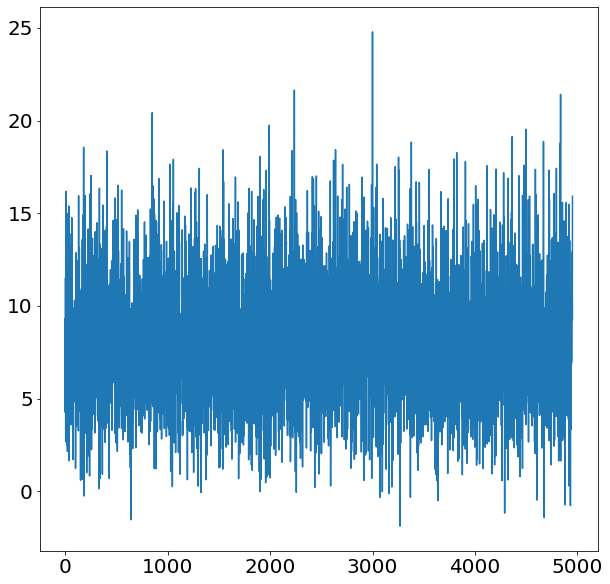

Text(0, 0.5, 'Frequency (MHz)')

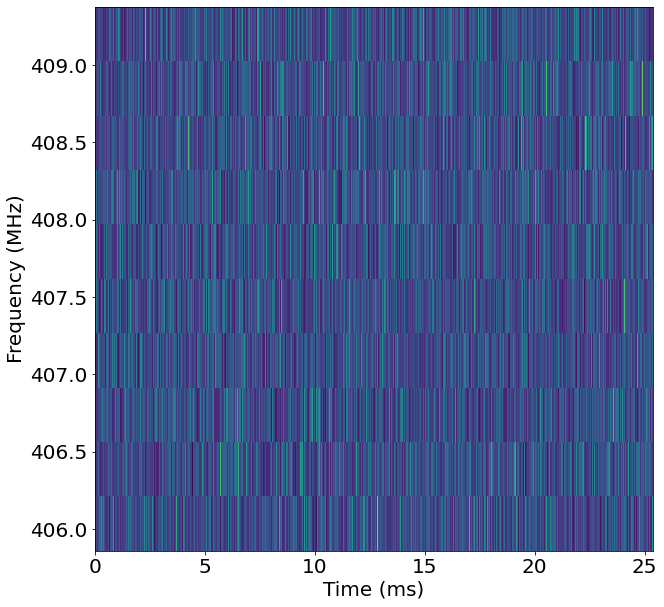

In [19]:
# Plot waterfall
freq_id, freq, power = get_snr(
    data, 
    DM=DM, 
    spectrum_lim=False,
    downsample=False
)

plt.plot(power.sum(axis=0))
plt.show()

plt.imshow(
    power,
    cmap="viridis",
    origin="upper",
    aspect="auto",
    interpolation="nearest",
    extent = [0, power.shape[-1] * 2.56e-3 * data["tiedbeam_power"].attrs['time_downsample_factor'], freq.min(), freq.max()]
)
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')